# Optimizing Convolutional Neural Networks for Hair Type Recognition

## Definition of the Problem 
The goal of this project is to develop a Convolutional Neural Network (CNN) model capable of classifying individuals' hair types based on specific features. The hair types include **coily**, **curly**, **straight**, and **wavy**. The model will be trained on a dataset consisting of labeled images of various hair types, with relevant features extracted from them. This model can be used in applications such as beauty industry AI tools, e-commerce (to recommend hair care products based on hair type), and even personalized advertising for beauty brands.

Understanding hair types is crucial, as different hair types have unique structural properties and distinct needs when it comes to products such as shampoos, conditioners, oils, and hair treatments. Hair type recognition allows people to make informed decisions about proper hair care to avoid damage and improve hair health over the long term. Additionally, it helps individuals choose the most suitable styles that enhance their natural hair texture, whether it is curly, straight, or coily.

Currently, hair type classification is done manually by professionals, or users rely on manual input to categorize their hair type. Automated classification would significantly reduce labor and improve customer experience. With this model, it can save time and reduce human error and provide a scalable solution for automating hair type classification. 

## Data Acquisition 
The dataset used for this project was sourced from the publicly available **Hair Type Dataset** on Kaggle, which contains 1,992 labeled images of individuals with different hair types (coily, curly, straight, wavy, and dreadlocks). However, dreadlocks will not be classified as a hair type in this model, as it is a hairstyle consisting of rope-like strands of hair.

Additional images were sourced from websites such as Google and Pinterest to ensure that each hair type classification contains at least 1,000 images. Specifically, there are **1,240 images for coily**, **1,430 for curly**, **1,227 for straight**, and **1,068 for wavy hair types**. The dataset is split into 80% for training and 20% for testing. This approach ensures that the dataset captures a wide variety of hair textures and styles, providing the model with a diverse and representative set of images for each hair type.

## Exploration and Analysis of Data
Before training the CNN model, we will explore the dataset to understand its structure. The dataset is organized into labeled folders for each hair type, allowing the model to learn distinct features that differentiate one type from another. Organized within a main **Dataset** directory, the images are split into subfolders for training and testing data for each hair type, including **coily**, **curly**, **straight** and **wavy**. This will help us better understand the distribution of the images and prepare the data for model training. 

## Data Preparation
For the data to be used in training the CNN, we need to perform several preprocessing steps:
- Resizing images to a consistent size before it can be fed into the CNN model.
- Applying transformations like rotation, zoom and flip to increase the variety of training data and prevent overfitting.
- Normalizing the pixel values to a range of 0 to 1.

In [21]:
# Loading the relevant libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Loading the path to dataset folders
train_dir = 'C:\\Users\\User\\Desktop\\Eda\'s Files\\Program\\CSC173 - CNN\\dataset\\train'
test_dir = 'C:\\Users\\User\\Desktop\\Eda\'s Files\\Program\\CSC173 - CNN\\dataset\\test'

In [12]:
# Count images in each class
def count_images(dataset_path):
    class_counts = {}
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len([f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))])
    return class_counts

# Display counts
print("Train Set Distribution:", count_images(train_dir))
print("Test Set Distribution:", count_images(test_dir))

# Plotting image distribution
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

Train Set Distribution: {'coily': 992, 'curly': 1144, 'straight': 984, 'wavy': 855}
Test Set Distribution: {'coily': 248, 'curly': 286, 'straight': 243, 'wavy': 213}


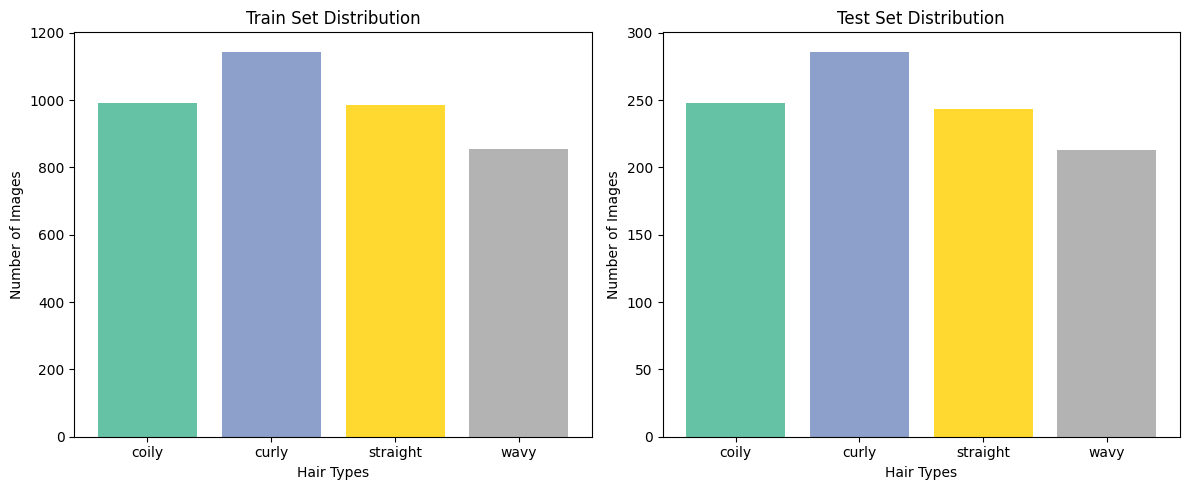

In [13]:
# Generate a list of colors
colors_train = plt.cm.Set2(np.linspace(0, 1, len(train_counts)))
colors_test = plt.cm.Set2(np.linspace(0, 1, len(test_counts)))

# Plot the set distribution 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(train_counts.keys(), train_counts.values(), color=colors_train)
ax1.set_title('Train Set Distribution')
ax1.set_xlabel('Hair Types')
ax1.set_ylabel('Number of Images')

ax2.bar(test_counts.keys(), test_counts.values(), color=colors_test)
ax2.set_title('Test Set Distribution')
ax2.set_xlabel('Hair Types')
ax2.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

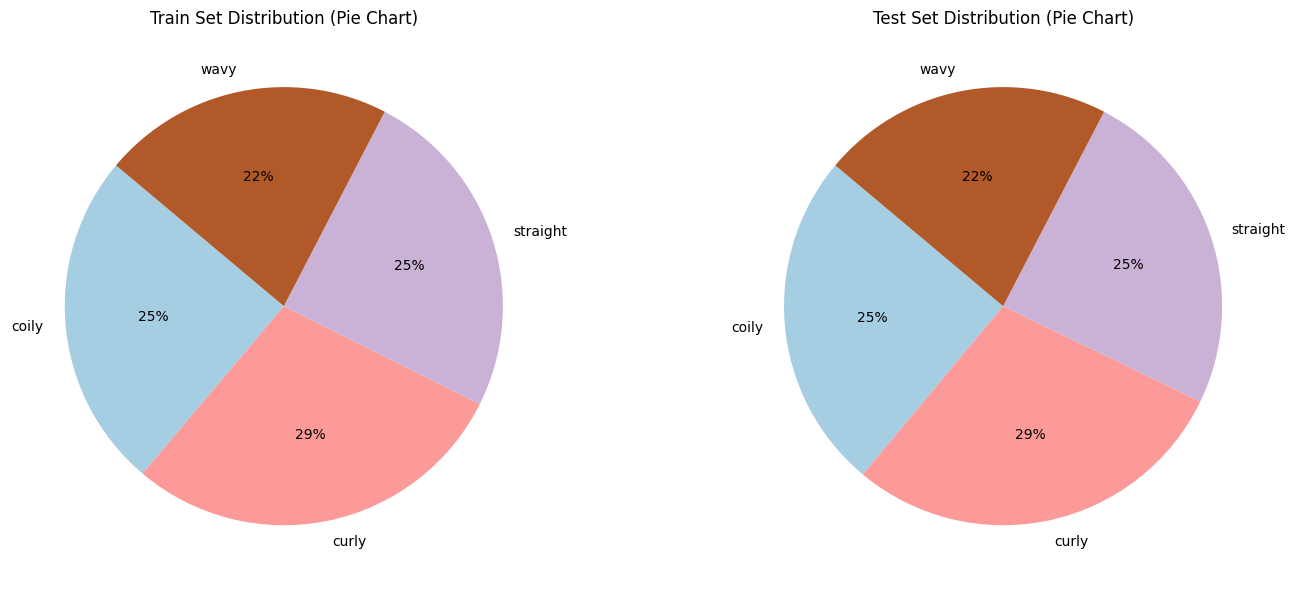

In [14]:
# Plotting pie chart for Train Set Distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Train Set Pie Chart
ax[0].pie(train_counts.values(), labels=train_counts.keys(), autopct='%.0f%%', startangle=140, colors=plt.cm.Paired(np.linspace(0, 1, len(train_counts))))
ax[0].set_title('Train Set Distribution (Pie Chart)')

# Test Set Pie Chart
ax[1].pie(test_counts.values(), labels=test_counts.keys(), autopct='%.0f%%', startangle=140, colors=plt.cm.Paired(np.linspace(0, 1, len(test_counts))))
ax[1].set_title('Test Set Distribution (Pie Chart)')

# Display the charts
plt.tight_layout()
plt.show()

Found 3975 images belonging to 4 classes.
Found 990 images belonging to 4 classes.


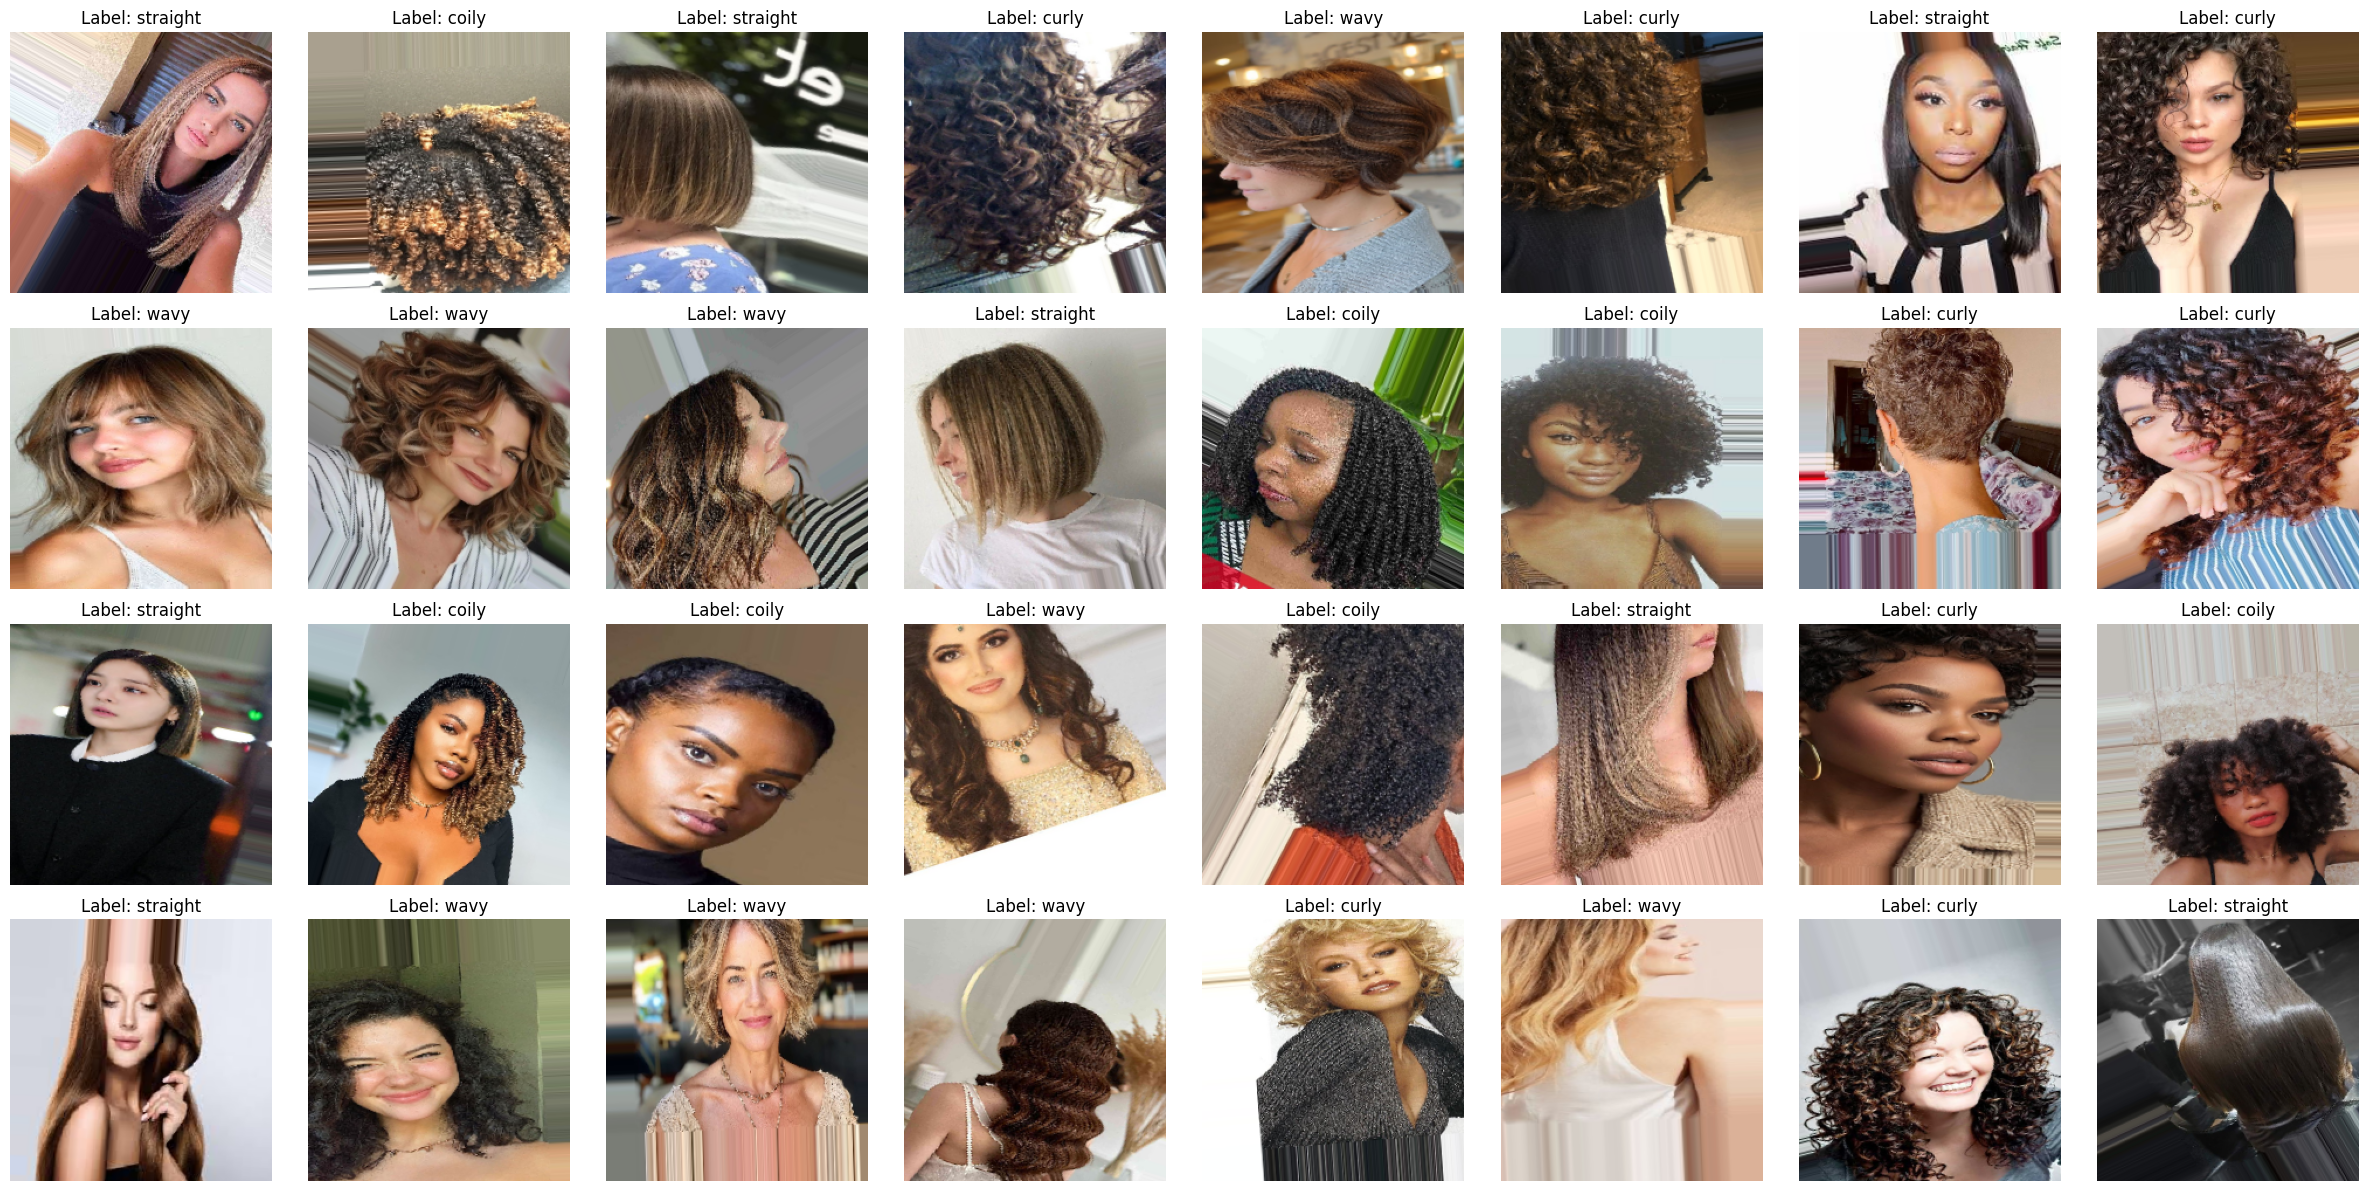

In [15]:
# Data generators 
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

img_height, img_width = 224, 224

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# Function to display a grid of images
def plot_images(images, labels, class_names, ncols=8):
    n_images = len(images)
    nrows = int(np.ceil(n_images / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.ravel()

    for i in range(n_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze())  
        label_index = np.argmax(labels[i])  
        ax.set_title(f"Label: {class_names[label_index]}")
        ax.axis('off')

    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of augmented images from the train data
images, labels = next(train_generator)

# Get the class names from the generator (folder names)
class_names = list(train_generator.class_indices.keys())

# Display the images in a grid
plot_images(images, labels, class_names)

In [16]:
# Data Analysis using Descriptive Statistics
# Convert the first batch of images to numpy array to get descriptive statistics
batch_images, _ = next(train_generator)
print(f'Mean pixel value: {np.mean(batch_images)}')
print(f'Standard deviation of pixel values: {np.std(batch_images)}')
print(f'Minimum pixel value: {np.min(batch_images)}')
print(f'Maximum pixel value: {np.max(batch_images)}')

Mean pixel value: 0.4550762474536896
Standard deviation of pixel values: 0.2852354347705841
Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [17]:
# CNN Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output units for 4 hair types
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify
model.summary()

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

c:\Users\User\Desktop\Eda's Files\Program\CSC173 - CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\User\Desktop\Eda's Files\Program\CSC173 - CNN\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.2746 - loss: 1.8981 - val_accuracy: 0.2808 - val_loss: 1.3880
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.3478 - loss: 1.2836 - val_accuracy: 0.3869 - val_loss: 1.2984
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.4466 - loss: 1.1847 - val_accuracy: 0.4374 - val_loss: 1.2476
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.4541 - loss: 1.1825 - val_accuracy: 0.4677 - val_loss: 1.2530
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.4936 - loss: 1.1039 - val_accuracy: 0.4808 - val_loss: 1.1982
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.5244 - loss: 1.0868 - val_accuracy: 0.5616 - val_loss: 1.0159
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5664 - loss: 1.0055 - val_accuracy: 0.5798 - val_loss: 1.0144
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.5852 - loss: 0.9736 - val_accu

In [18]:
# Classification Report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('\nClassification Report:')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step

Classification Report:
              precision    recall  f1-score   support

       coily       0.28      0.35      0.31       248
       curly       0.28      0.29      0.29       286
    straight       0.23      0.21      0.22       243
        wavy       0.23      0.17      0.20       213

    accuracy                           0.26       990
   macro avg       0.26      0.26      0.26       990
weighted avg       0.26      0.26      0.26       990



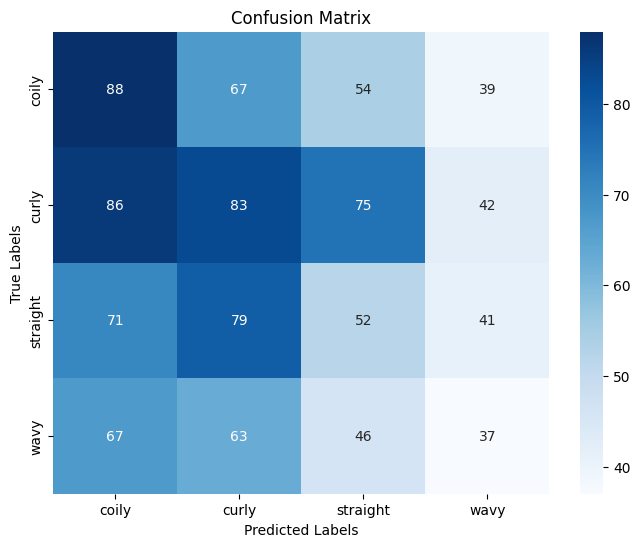

In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

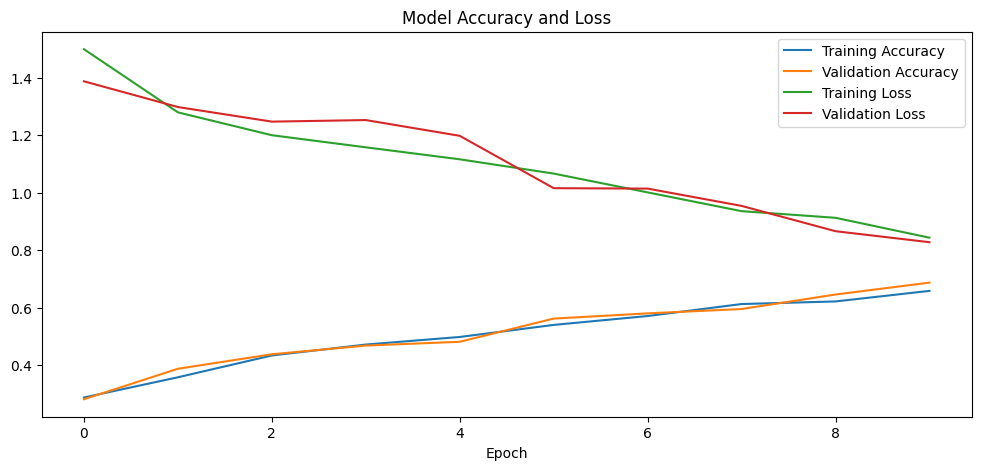

In [20]:
# Plotting History
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()